In [ ]:
!pip install pyspark

# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA

# Initialize Spark session
spark = SparkSession.builder \
    .appName("RandomForestModel") \
    .getOrCreate()

In [ ]:
# Load the data
data_path = "Updated_data.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Preprocessing
data = data.withColumn("ObesityLevel", data["ObesityLevel"].cast("double"))

# Convert categorical variables to factors if not already done
categorical_cols = ["Gender", "family_history_with_overweight", "FCHighCal", "SMOKE", "MonitorCalory", "Alcohol", "MTRANS"]
for col in categorical_cols:
    data = data.withColumn(col, data[col].cast("double"))

In [ ]:
# Create feature vector for untransformed data
feature_cols = data.columns[1:-1]  # Exclude target variable and non-numeric columns
assembler_untransformed = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_untransformed = assembler_untransformed.transform(data)

# Train/test split for untransformed data
seed = 1999
(training_data, test_data) = data_untransformed.randomSplit([0.7, 0.3], seed=seed)

# Train a random forest model for untransformed data
rf_model_untransformed = RandomForestClassifier(labelCol="ObesityLevel", featuresCol="features", numTrees=500, seed=seed)
rf_model_untransformed = rf_model_untransformed.fit(training_data)

# Evaluate Model Performance
evaluator = MulticlassClassificationEvaluator(labelCol="ObesityLevel", predictionCol="prediction", metricName="accuracy")

# Evaluate untransformed model
predictions_untransformed = rf_model_untransformed.transform(test_data)
accuracy_untransformed = evaluator.evaluate(predictions_untransformed)

print("Accuracy for untransformed data:", accuracy_untransformed)

Accuracy for untransformed data: 0.8032414910858995


In [ ]:
# Perform PCA for feature transformation
pca = PCA(k=6, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data_untransformed)
data_transformed = pca_model.transform(data_untransformed)

# Train/test split for transformed data
(training_data_transformed, test_data_transformed) = data_transformed.randomSplit([0.7, 0.3], seed=seed)

# Train a random forest model for transformed data
rf_model_transformed = RandomForestClassifier(labelCol="ObesityLevel", featuresCol="pca_features", numTrees=500, seed=seed)
rf_model_transformed = rf_model_transformed.fit(training_data_transformed)

# Evaluate transformed model
predictions_transformed = rf_model_transformed.transform(test_data_transformed)
accuracy_transformed = evaluator.evaluate(predictions_transformed)

print("Accuracy for transformed data:", accuracy_transformed)

Accuracy for transformed data: 0.8160453808752026


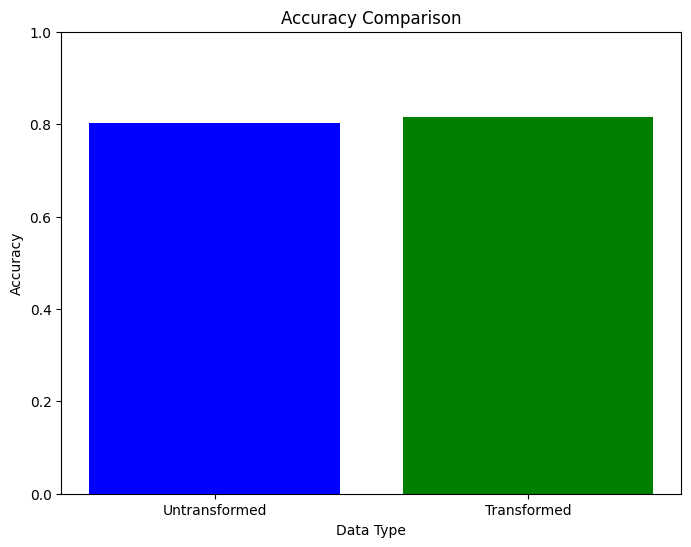

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have accuracy results for both untransformed and transformed data
accuracy_results = [accuracy_untransformed, accuracy_transformed]
data_types = ['Untransformed', 'Transformed']

# Create a DataFrame to hold the results
evaluation_results_pd = spark.createDataFrame(zip(data_types, accuracy_results), schema=["Data Type", "Accuracy"])

# Convert to Pandas DataFrame for plotting
evaluation_results_pd = evaluation_results_pd.toPandas()

# Plot the evaluation results
plt.figure(figsize=(8, 6))
plt.bar(evaluation_results_pd["Data Type"], evaluation_results_pd["Accuracy"], color=['blue', 'green'])
plt.title("Accuracy Comparison")
plt.xlabel("Data Type")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Set y-axis limit to between 0 and 1
plt.show()


In [ ]:
# Stop the SparkSession
spark.stop()